In [1]:
# Just some boilerplate code
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm

from matplotlib import rcParams

rcParams["figure.figsize"] = (12.0, 6.0)

rng = np.random.default_rng()
pdf_domain = (-3, 3)
pdf_range = (0, 1.0)

bins = np.linspace(*pdf_domain, 100)
centres = (bins[1:] + bins[:-1]) / 2

kw = {"histtype": "step", "bins": bins}


# Fcn for gen with efficiency- return n_generated and an array of accepted
def sample_with_efficiency(N, pdf, efficiency):
    a = lambda x: pdf(x) * efficiency(x)
    
    points = np.zeros(N)
    num_accepted = 0
    num_generated = 0
    
    with tqdm(total=N) as pbar:
        while num_accepted < N:
            # Generate a point
            x = pdf_domain[0] + (pdf_domain[1] - pdf_domain[0]) * rng.random()
            y = pdf_range[0] + (pdf_range[1] - pdf_range[0]) * rng.random()

            if y < a(x):
                points[num_accepted] = x
                num_accepted += 1
                pbar.update(1)
            
            if y < pdf(x):
                num_generated += 1

    return points, num_generated

We have generated some MC samples following three distributions, labelled "RS"; "WS"; and phsp:

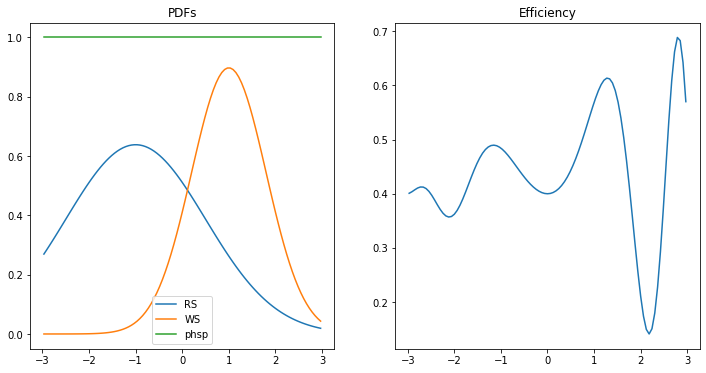

In [2]:
# Model "PDFs" - not normalised (on purpose, since in reality amplitude models are rarely normalised)
def A_rs(x):
    return 2.4 * norm.pdf(x, loc=-1.0, scale=1.5)

def A_ws(x):
    return 1.8 * norm.pdf(x, loc=1.0, scale=0.8)

def A_phsp(x):
    return int(pdf_domain[0] < x < pdf_domain[1])

def e(x):
    return 0.4 +  0.05 * (x + 3.0) * np.sin(x*x)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(centres, [A_rs(i) for i in centres], label="RS")
ax[0].plot(centres, [A_ws(i) for i in centres], label="WS")
ax[0].plot(centres, [A_phsp(i) for i in centres], label="phsp")

ax[1].plot(centres, [e(i) for i in centres])

ax[0].set_title("PDFs")
ax[1].set_title("Efficiency")
ax[0].legend()

plt.show()

In [3]:
N_rs, N_ws, N_phsp = 200000, 4000, 300000
    
# Gen model w/ efficiency
rs_mc, gen_rs = sample_with_efficiency(N_rs, A_rs, e)
ws_mc, gen_ws = sample_with_efficiency(N_ws, A_ws, e)
phsp_mc, gen_phsp = sample_with_efficiency(N_phsp, A_phsp, e)

combined_mc = np.concatenate((rs_mc, ws_mc, phsp_mc))

100%|██████████| 300000/300000 [00:02<00:00, 113735.65it/s]


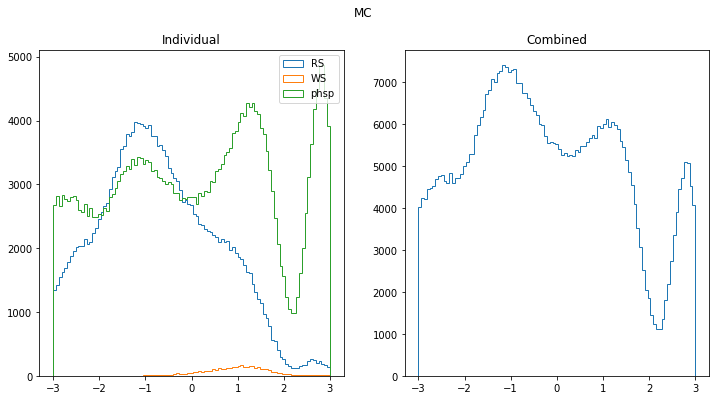

In [4]:
fig, ax = plt.subplots(1, 2,figsize=(12.0, 6.0))

ax[0].hist(rs_mc, **kw, label="RS")
ax[0].hist(ws_mc, **kw, label="WS")
ax[0].hist(phsp_mc, **kw, label="phsp")
ax[1].hist(combined_mc, **kw)

ax[0].legend()

ax[0].set_title("Individual")
ax[1].set_title("Combined")
fig.suptitle("MC")

plt.show()


We know what the combined target distribution should look like, since we know the original statistics

In [5]:
# Plots of generated models in the right proportion
rs_model, _ = sample_with_efficiency(gen_rs, A_rs, lambda x: 1)
ws_model, _ = sample_with_efficiency(gen_ws, A_ws, lambda x: 1)
phsp_model, _ = sample_with_efficiency(gen_phsp, A_phsp, lambda x: 1)

combined_model = np.concatenate((rs_model, ws_model, phsp_model))

100%|██████████| 682171/682171 [00:01<00:00, 380895.96it/s]


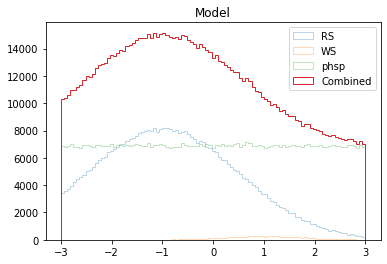

In [6]:
plt.hist(rs_model, **kw, label="RS", alpha=0.3)
plt.hist(ws_model, **kw, label="WS", alpha=0.3)
plt.hist(phsp_model, **kw, label="phsp", alpha=0.3)
plt.hist(combined_model, **kw, label="Combined")


plt.legend()
plt.title("Model")

plt.show()

We can use this to reconstruct the efficiency:

In [7]:
def scaled_efficiency(model, mc, avg_efficiency):
    """
    Bin two datasets, take the ratio of the resulting histograms then scale the ratio to have the desired average
    
    """   
    mc_hist, _ = np.histogram(mc, bins)
    model_hist, _ = np.histogram(model, bins)
    
    hist_ratio = mc_hist / model_hist

    scale_factor = avg_efficiency / np.mean(hist_ratio)
    return hist_ratio * scale_factor


measured_efficiency = scaled_efficiency(rs_model, rs_mc, np.mean([e(i) for i in centres]))

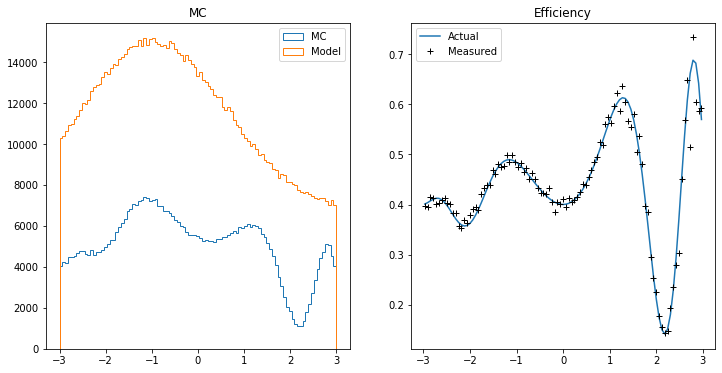

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12.0, 6.0))

ax[0].hist(combined_mc, **kw, label="MC")
ax[0].hist(combined_model, **kw, label="Model")


ax[1].plot(centres, [e(i) for i in centres], label="Actual")
ax[1].plot(centres, measured_efficiency, "k+", label="Measured")

ax[0].legend()
ax[1].legend()

ax[0].set_title("MC")
ax[1].set_title("Efficiency")

plt.show()